In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from preprocess import preprocessing
#from read_mias import *
import config
from object_detector import ObjectDetector
from custom_tensor_dataset import CustomTensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
import pickle
import torch

import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Implementation References:

https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

https://medium.com/@sharathhebbar24/object-detection-from-scratch-5ec93520adda

https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn

https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/3


# Preparation

In [2]:
dir = os.getcwd()
info = pd.read_csv(dir +'/mias_info/labels.txt', sep = ' ', header = None)
info.columns = ['refno', 'tissue', 'class', 'severity','x','y','r']
info['severity'] = info['severity'].fillna('N')
info['image_id'] = info.refno.str.split('b', expand = True)[1].astype(int) -1
info.head()


,refno,tissue,class,severity,x,y,r,image_id
0,mdb001,G,CIRC,B,535,425,197.0,0
1,mdb002,G,CIRC,B,522,280,69.0,1
2,mdb003,D,NORM,N,NaN,NaN,NaN,2
3,mdb004,D,NORM,N,NaN,NaN,NaN,3
4,mdb005,F,CIRC,B,477,133,30.0,4


In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

dataset = CustomTensorDataset(data_transform)


def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=config.BATCH_SIZE, 
                                          collate_fn=collate_fn)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break



cpu
[{'boxes': tensor([[0.3301, 0.2227, 0.7148, 0.6074]]), 'labels': tensor([1]), 'image_id': tensor([0])}, {'boxes': tensor([[0.4424, 0.2061, 0.5771, 0.3408]]), 'labels': tensor([1]), 'image_id': tensor([1])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([2])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([3])}]


# Model Selection

Currently using an RCNN like the third reference

In [7]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# 3 features because using classifying into 3 severities: 
# normal, benign, malignant

model = get_model_instance_segmentation(3)



c:\Users\Student\bioe486\envs\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Student\bioe486\envs\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

`config` file currently set for

20 epochs

batch size 32

change as necessary in the `config` before running

In [ ]:
num_epochs = config.NUM_EPOCHS
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(23.4689, grad_fn=<AddBackward0>)
tensor(13.8072, grad_fn=<AddBackward0>)


# Predictions

In [24]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break


In [25]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[0.0000, 0.0105, 1.2621, 4.5895]], grad_fn=<StackBackward0>),
  'labels': tensor([1]),
  'scores': tensor([0.0967], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[0.0000, 0.0109, 0.8502, 4.7871]], grad_fn=<StackBackward0>),
  'labels': tensor([1]),
  'scores': tensor([0.0967], grad_fn=<IndexBackward0>)}]

Prediction


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

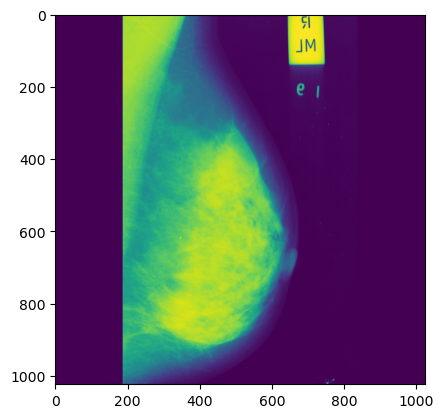

In [28]:
from plotting import plot_image
idx = 3
print("Prediction")
plot_image(imgs[idx], preds[idx])
print("Target")


{'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([2])}


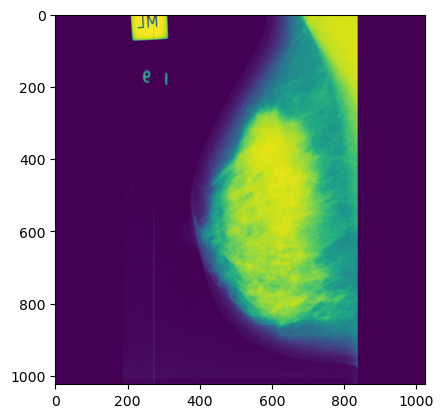

In [27]:
img = imgs[idx]
annot = annotations[idx]
print(annot)
plot_image(imgs[idx], annotations[idx])